In [40]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [41]:
pd.set_option("display.max_columns", None)

In [42]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('sectors_walmart.csv', index_col='PID')
data = data.merge(sector[['Sector','DfromWalmart']], on='PID')
data.shape

(2579, 83)

In [4]:
# Define y as "SalePrice"
y = data.SalePrice.copy()

## Quick look at <span style="color:darkred">Sales Prices</span> 💵

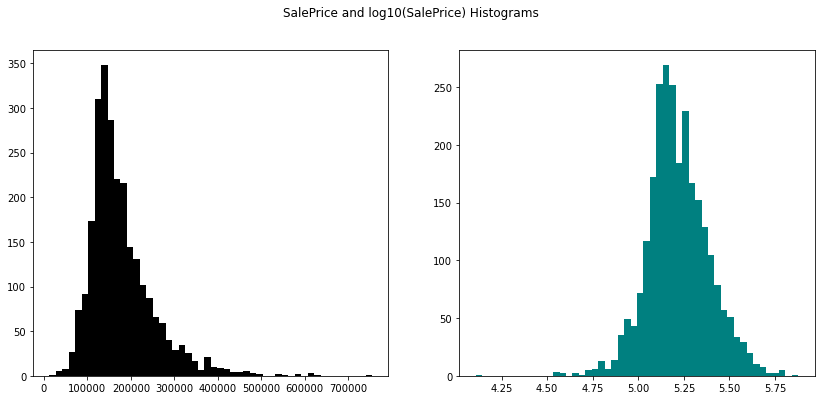

In [5]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice and log10(SalePrice) Histograms')

ax1.hist(y, bins=50,color='k');
ax2.hist(np.log10(y), bins=50, color='teal');

# Type of House

####  MSSubClass: Type of dwelling
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

#### Convert to:
    1Fl = 20,30,40,45,50
    2Fl = 60,70,75
    SPLIT = 80,85
    PUD1Fl = 120,150
    PUD2Fl = 160,180
    DUP2FAM = 90,190

In [6]:
conv_dict = {}
for k in [20,30,40,45,50]:
    conv_dict[k] = '1Fl'
for k in [60,70,75]:
    conv_dict[k] = '2Fl'
for k in [80,85]:
    conv_dict[k] = 'SPLIT'
for k in [120,150]:
    conv_dict[k] = '1FlPUD'
for k in [160,180]:
    conv_dict[k] = '2FlPUD'
for k in [90,190]:
    conv_dict[k] = 'DUP2FAM'

data.loc[:,'MSSubClass'] = data.loc[:,'MSSubClass'].apply(lambda r: conv_dict[r])

In [7]:
data.MSSubClass.value_counts().sort_index()

1Fl        1343
1FlPUD      170
2Fl         639
2FlPUD      135
DUP2FAM     140
SPLIT       152
Name: MSSubClass, dtype: int64

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

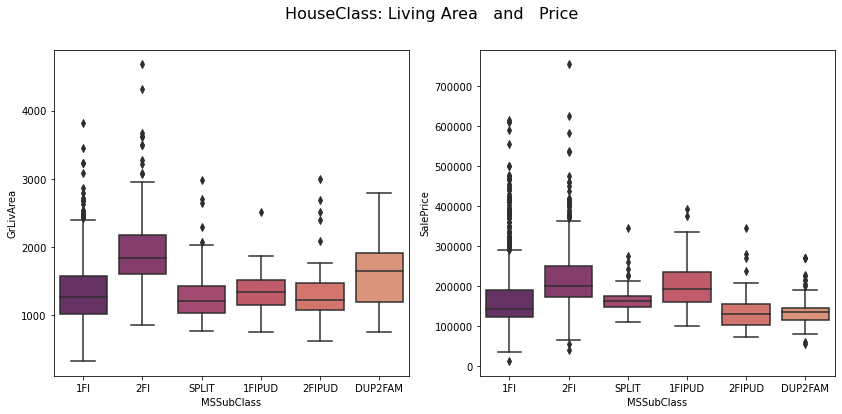

In [8]:
#Plot NEW HouseClass
sns.set_palette('flare_r')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('HouseClass: Living Area   and   Price', size=16)

sns.boxplot(ax=ax1,x=data.MSSubClass, y=data.GrLivArea)
sns.boxplot(ax=ax2,x=data.MSSubClass, y=y)

## 🤦‍♂️ David's: 
### GarageCars, BsmtQual

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

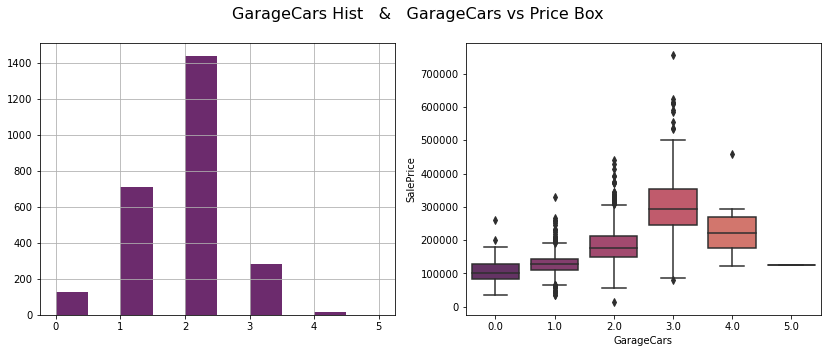

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('GarageCars Hist   &   GarageCars vs Price Box', size=16)

data['GarageCars'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['GarageCars'],y=y)

### <span style="color:Teal">Combine 4 & 5 into 3, and fill NaN with 0</span>

In [10]:
data['GarageCars'].replace({np.NaN:0,4:3,5:3}, inplace=True)

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

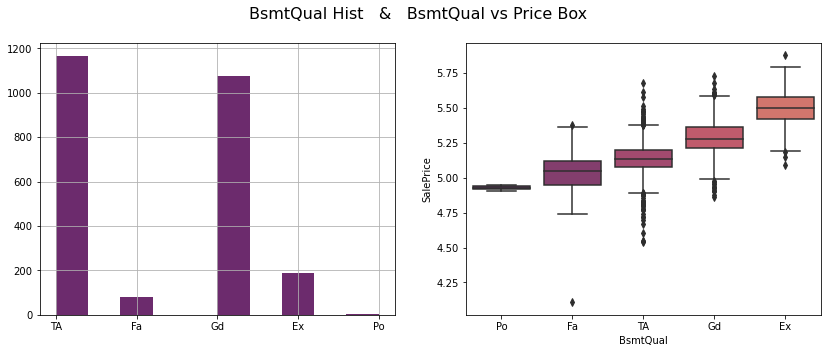

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('BsmtQual Hist   &   BsmtQual vs Price Box', size=16)

data['BsmtQual'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['BsmtQual'],y=np.log10(y),order=['Po','Fa','TA','Gd','Ex'])

## 🤷‍♂️ Karl's: 
### Foundation, PavedDrive, BsmtFullBath + BsmtHalfBath + FullBath + HalfBath, BedroomAbvGr, TotRmsAbvGrd

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

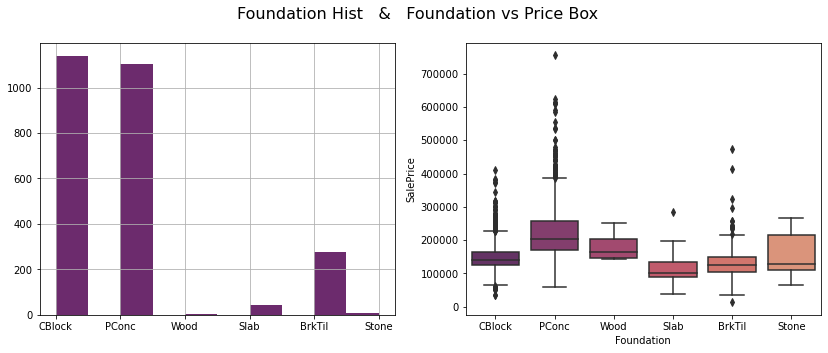

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Foundation Hist   &   Foundation vs Price Box', size=16)

data['Foundation'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['Foundation'],y=y)

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice'>

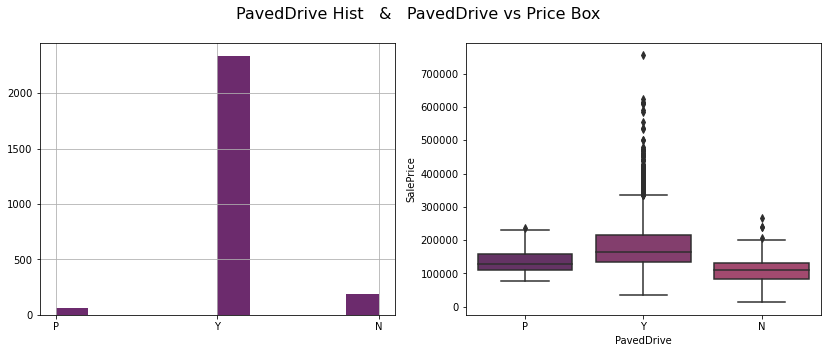

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('PavedDrive Hist   &   PavedDrive vs Price Box', size=16)

data['PavedDrive'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['PavedDrive'],y=y)

### 🐦NewFeats: <span style="color:Red">AllBathBsmt</span> &  <span style="color:Red">AllBathAbv</span> (fill NaN with 0)
* AllBathBsmt = BsmtFullBath + BsmtHalfBath (Full = 1, Half = 0.5)
* AllBathAbv = FullBath + HalfBath (Full = 1, Half = 0.5)

In [14]:
data['AllBathBsmt'] = data.BsmtFullBath + data.BsmtHalfBath/2
data['AllBathBsmt'].replace({np.NaN:0}, inplace=True)
data['AllBathAbv'] = data.FullBath + data.HalfBath/2
data['AllBathAbv'].replace({np.NaN:0}, inplace=True)

<AxesSubplot:xlabel='AllBathAbv', ylabel='SalePrice'>

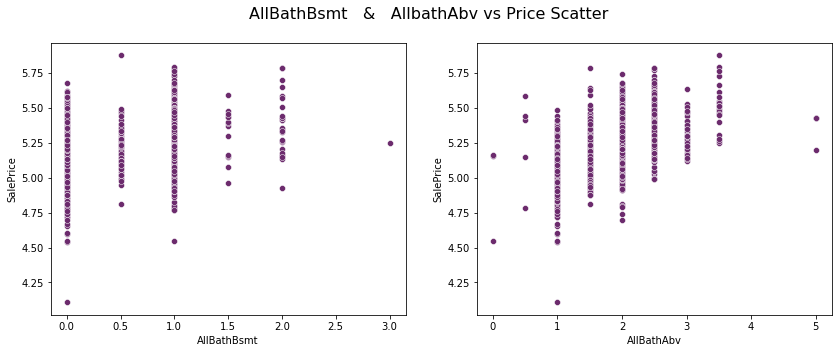

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('AllBathBsmt   &   AllbathAbv vs Price Scatter', size=16)

sns.scatterplot(ax=ax1, x=data['AllBathBsmt'],y=np.log10(y))
sns.scatterplot(ax=ax2, x=data['AllBathAbv'],y=np.log10(y))

### TotalBedrooms vs TotalAllRooms

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='SalePrice'>

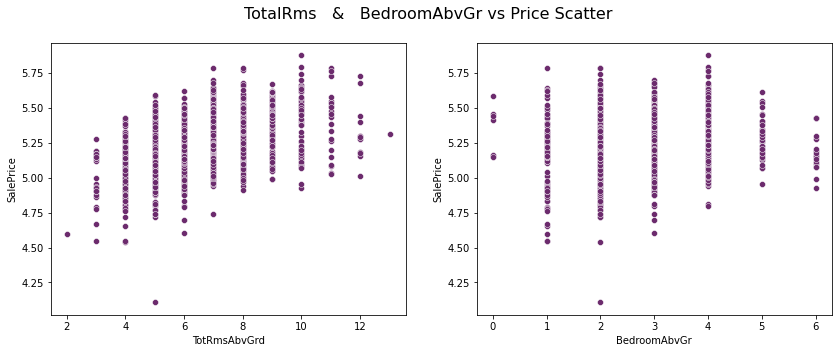

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('TotalRms   &   BedroomAbvGr vs Price Scatter', size=16)

sns.scatterplot(ax=ax1, x=data['TotRmsAbvGrd'],y=np.log10(y))
sns.scatterplot(ax=ax2, x=data['BedroomAbvGr'],y=np.log10(y))

## Total Rooms maybe better than only Bedrooms

## 🧏‍♂️ Tony's
### Fireplaces, HeatingQC

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

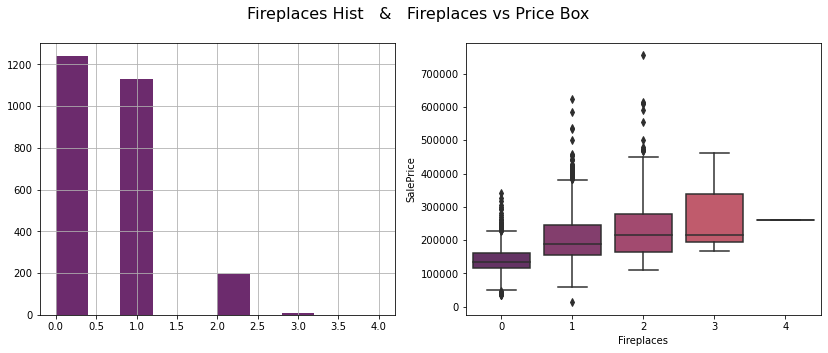

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Fireplaces Hist   &   Fireplaces vs Price Box', size=16)

data['Fireplaces'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['Fireplaces'],y=y)

### <span style="color:Teal">Combine 3 & 4 into 2, and fill NaN with 0</span>

In [18]:
data['Fireplaces'].replace({np.NaN:0,3:2,4:2}, inplace=True)

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

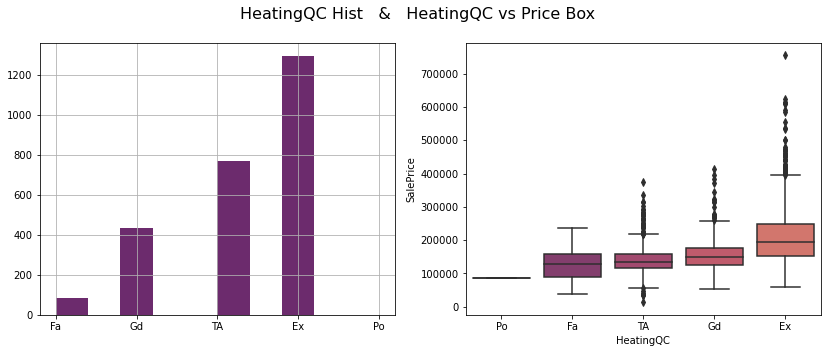

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('HeatingQC Hist   &   HeatingQC vs Price Box', size=16)

data['HeatingQC'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['HeatingQC'],y=y, order=['Po','Fa','TA','Gd','Ex'])

## 👴 Daniel's
### Neighborhood, YearBuilt, OverallQual,

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

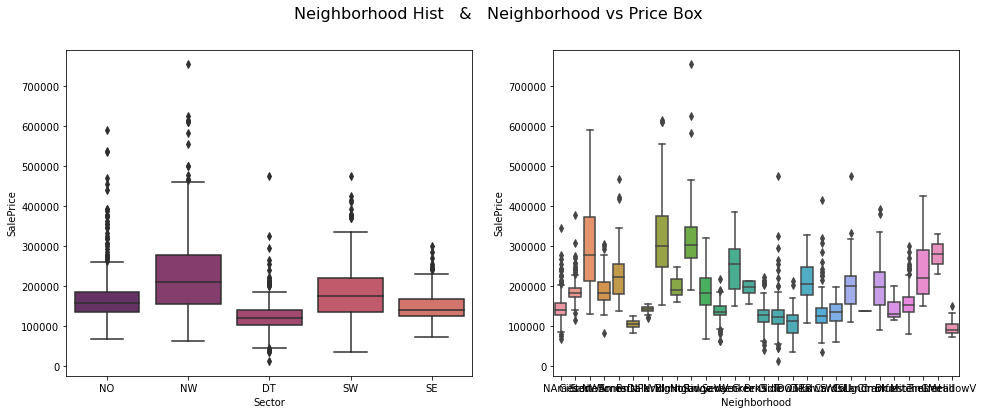

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Neighborhood Hist   &   Neighborhood vs Price Box', size=16)

sns.boxplot(ax=ax1, x=data['Sector'],y=y)
sns.boxplot(ax=ax2, x=data['Neighborhood'],y=y)

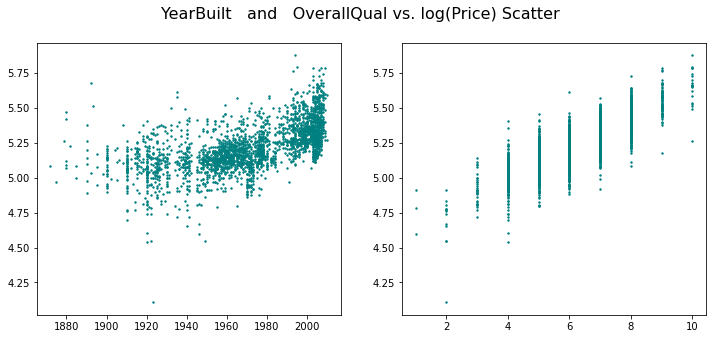

In [21]:
#Plot Year Built
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('YearBuilt   and   OverallQual vs. log(Price) Scatter', size=16)

ax1.scatter(x=data.YearBuilt,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=data.OverallQual,y=np.log10(y),s=2,c='teal')

## <span style="color:darkred">Size Related</span> Features 📐 (continuous)
* Columns with "SF" / "AREA" / "Porch Size"

In [22]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

### 🐦New Feat <span style="color:blue">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [23]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [24]:
#Drop unnecessary columns
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

<AxesSubplot:>

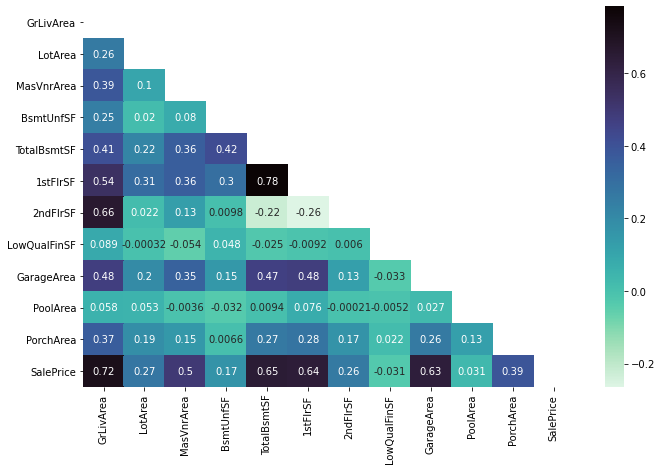

In [25]:
corr = pd.concat([size_related, y], axis=1).corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

#### Investigate GrLivArea (largest correlation with Sale Price 0.72)

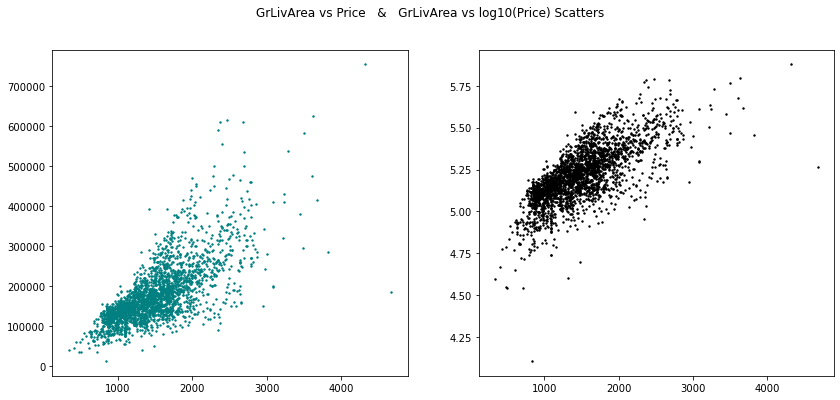

In [26]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('GrLivArea vs Price   &   GrLivArea vs log10(Price) Scatters')

ax1.scatter(x=size_related.GrLivArea,y=y,s=2,c='teal')
ax2.scatter(x=size_related.GrLivArea,y=np.log10(y),s=2,c='k')

### All Others

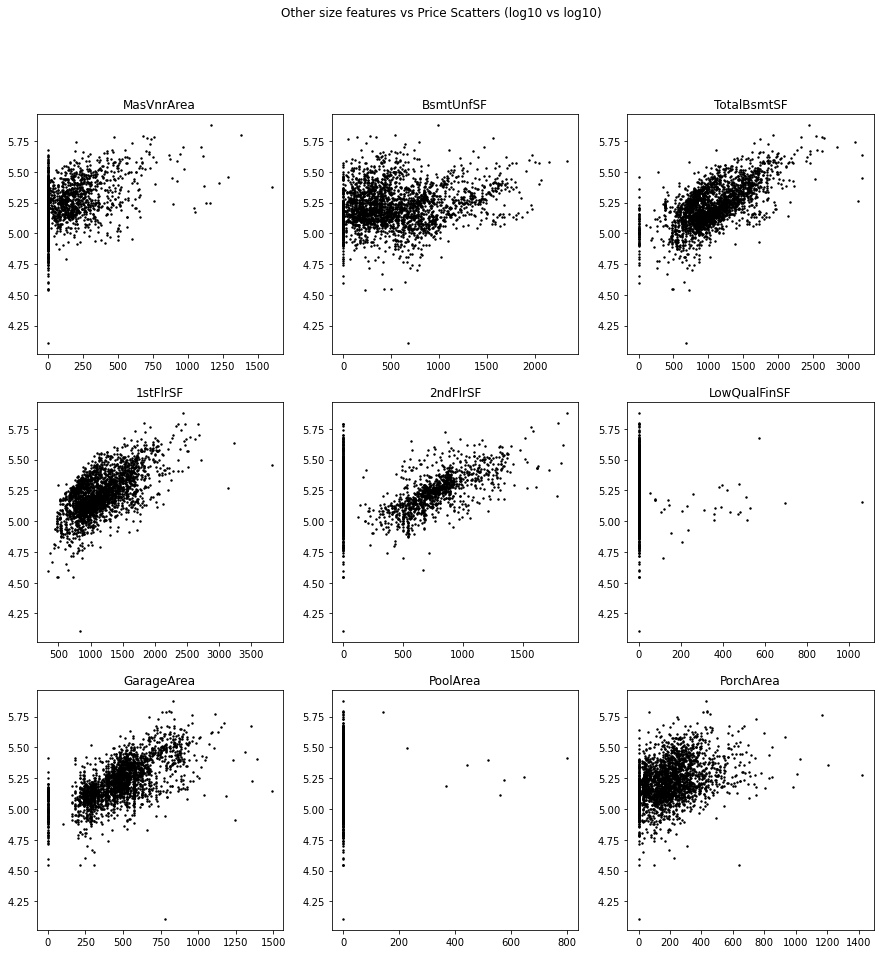

In [27]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Other size features vs Price Scatters (log10 vs log10)')

for idx, COL in enumerate(size_related.drop(['GrLivArea','LotArea'],axis=1).columns):
    ax[idx//3,idx%3].scatter(x=size_related[COL],y=np.log10(y), s=2,c='k')
    ax[idx//3,idx%3].set_title(str(COL))

In [28]:
size_related['ALLSF'] = size_related['1stFlrSF'] + \
    size_related['2ndFlrSF'] + size_related.TotalBsmtSF + \
    size_related.GarageArea + size_related.PorchArea

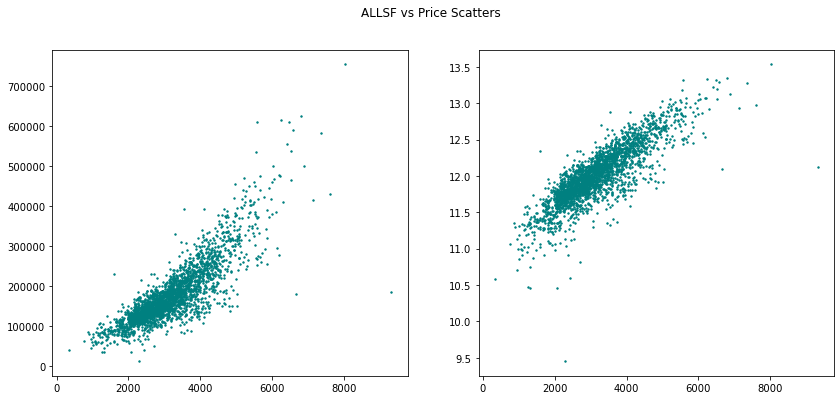

In [29]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('ALLSF vs Price Scatters')

ax1.scatter(x=size_related.ALLSF,y=y,s=2,c='teal')
ax2.scatter(x=size_related.ALLSF,y=np.log(y),s=2,c='teal')

## 📉 Prepare for Modeling

In [34]:
X = data[['MSSubClass','GarageCars', 'GarageType','BsmtQual','Foundation', 'PavedDrive', 'TotalBsmtSF',
          'AllBathBsmt', 'AllBathAbv', 'TotRmsAbvGrd', 'Fireplaces', 'HeatingQC', 'Neighborhood', 
          'Sector', 'YearBuilt', 'OverallQual', 'LotFrontage','SalePrice','DfromWalmart']]

In [35]:
X = X.join(size_related[['1stFlrSF','2ndFlrSF','GarageArea','PorchArea','ALLSF']],on='PID')

#### Treat Missing Data

In [36]:
X.isna().sum().sort_values(ascending=False).head()

LotFrontage    462
GarageType     127
BsmtQual        69
TotalBsmtSF      1
MSSubClass       0
dtype: int64

In [37]:
# Replace NaN with 0
X.LotFrontage.replace(np.NaN,0, inplace=True)
X.TotalBsmtSF.replace(np.NaN,0, inplace=True)

### Export to CSV

In [38]:
X.head()

,MSSubClass,GarageCars,GarageType,BsmtQual,Foundation,PavedDrive,TotalBsmtSF,AllBathBsmt,AllBathAbv,TotRmsAbvGrd,Fireplaces,HeatingQC,Neighborhood,Sector,YearBuilt,OverallQual,LotFrontage,SalePrice,DfromWalmart,1stFlrSF,2ndFlrSF,GarageArea,PorchArea,ALLSF
PID,,,,,,,,,,,,,,,,,,,,,,,,
526301100,1Fl,2.0,Attchd,TA,CBlock,P,1080.0,1.0,1.0,7,2,Fa,NAmes,NO,1960,6,141.0,215000,2.675260,1656,0,528.0,272,3536.0
526302030,1Fl,2.0,Attchd,TA,CBlock,Y,1178.0,1.0,2.0,5,0,Gd,NAmes,NO,1954,6,0.0,149900,2.667153,1293,0,452.0,280,3203.0
526302040,1Fl,1.0,Attchd,TA,CBlock,Y,1008.0,1.0,1.0,5,2,TA,NAmes,NO,1956,6,85.0,157500,2.659026,1024,0,313.0,280,2625.0
526302110,1Fl,1.0,Attchd,Fa,CBlock,Y,882.0,0.0,1.0,5,0,TA,NAmes,NO,1956,6,74.0,124500,2.613583,882,0,502.0,0,2266.0
526302120,1Fl,3.0,Attchd,TA,CBlock,Y,1617.0,0.0,1.5,7,1,Fa,NAmes,NO,1957,5,0.0,169000,2.614917,1797,0,963.0,0,4377.0


In [39]:
X.to_csv('model_data.csv')